# Code to simulate COVID-19 epidemic using a modified stochastic SEIR model to include Asymptomatic, Testing and Quarantine Effects

## Somnath Mondal

### Ref: Atkins (2010) PhD Dissertation

In [56]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

%matplotlib inline
from IPython.display import display, HTML

print( 'Updated ', dt.datetime.now())

Updated  2020-04-06 08:45:32.628000


### Define Functions for Iteration 
#### (Scroll below for main code)

In [92]:
def update(old_pop, Parameters, change, rate):
    
    #dt = 0.01
    #new_pop = np.array([49995, 1, 1, 0, 0, 0])
    beta = Parameters[0]
    delta1 = Parameters[1]
    gamma1 = Parameters[2]
    theta = Parameters[3]
    kappa = Parameters[4]
    mu1 = Parameters[5]
    p_s = Parameters[6]
    gamma3 = Parameters[7]
    mu2 = Parameters[8]
    N = Parameters[9]
    
    S = old_pop[0]
    E = old_pop[1]
    I = old_pop[2]
    A = old_pop[3]
    Q = old_pop[4]
    R = old_pop[5]
    
    
       
    
    rate[0] = beta*S*(I+delta1*A)/N 
    rate[1] = p_s*kappa*E
    rate[2] = (1.-p_s)*kappa*E
    rate[3] = gamma1*I
    rate[4] = theta*I
    rate[5] = mu1*I
    rate[6] = gamma1*A
    rate[7] = gamma3*Q
    rate[8] = mu2*Q
    

    
    u1 = np.random.rand()
    u2 = np.random.rand()
    
    if np.sum(rate)>0:
        dt = -np.log(u2)/(np.sum(rate))
    else:
        return()
    
    event = np.min(np.where(np.cumsum(rate)>=u1*np.sum(rate)))
    new_pop = old_pop + change[event,:]
    
    return dt, new_pop

    

def Stoch_Iteration(Time, Initial, Parameters):
    
    S=Initial[0]
    E=Initial[1]
    I=Initial[2]
    A=Initial[3]
    Q=Initial[4]
    R=Initial[5]
    
    change = np.zeros([9, 6])
    
    change[0,:]=[-1, +1, 0, 0, 0, 0]
    change[1,:]=[0, -1, +1, 0, 0, 0]
    change[2,:]=[0, -1, 0, +1, 0, 0]
    change[3,:]=[0, 0, -1, 0, 0, +1]
    change[4,:]=[0, 0, -1, 0, +1, 0]
    change[5,:]=[0, 0, -1, 0, 0, 0]
    change[6,:]=[0, 0, 0, -1, 0, +1]
    change[7,:]=[0, 0, 0, 0, -1, +1]
    change[8,:]=[0, 0, 0, 0, -1, +1]
    
    T = np.array(([0.],[0.]), dtype=float)
    pop = np.zeros([2,6])
    pop[0,:] = [S, E, I, A, Q, R]
    old_pop = pop[0,:]
    j = 0
    rate = np.zeros([9]) 
    
    while (T[j]<Time[1]):
        [dt, new_pop] = update(old_pop, Parameters, change, rate)
        j = j + 1
        T[j] = T[j-1]+dt
        pop[j,:] = new_pop
        old_pop = new_pop       
        if j==(np.size(T)-1):
            T = np.append(T,np.zeros_like(T))
            pop = np.append(pop, np.zeros_like(pop),axis=0)
                 
    return T[1:j], pop[1:j,:]

### Initialize Parameters

There are 6 compartments of population - Susceptible (S), Exposed (E), Infected Symptomatic (I$_S$), Infected Asymptomatic (I$_A$), Quarantined (Q), and Removed/Recovered (R). The transfer between these groups are governed by the following parameters.

Unit of time is in days.

$\beta$= Infectious contact rate or Average number of contacts per person per unit time including probability of transmittion infection, controls S to E

$\kappa$ = Latency rate or inverse of incubation time period $T_{inc}^{-1}$ , controls E to I

$p_{s}$ = Fraction of exposed that develop symptoms, E to I$_S$

$\delta_1$ = Reduced infectivity of Asymptomatic I$_A$

$\gamma_1$ = Recovery rate of symptomatic I, controls I$_S$ to R, inverse of recovery time period $T_{rec, S}^{-1}$ 

$\gamma_2$ = Recovery rate of Asymptomatic I, controls I$_A$ to R, inverse of recovery time period $T_{rec, A}^{-1}$

$\gamma_3$ = Recovery rate of quarantined, controls Q to R, inverse of recovery time period $T_{rec, Q}^{-1}$

Assume, $\gamma_1 = \gamma_2 = \gamma_3$

$\theta$ = Rate of testing and removal to quarantine, controls I$_S$ to Q. For e.g. if quarantined 4 days after showing symptoms, then $\theta = 1/4$

$\mu_1$ = Death rate due to infection, controls I$_S$ to R by death

$\mu_2$ = Death rate due to infection in Quarantine, controls Q to R by death

In [98]:
print( 'Updated ', dt.datetime.now())

beta = 2.34      # contact rate per person per day
kappa = 1/5.     # Incubation period = 5 days
p_s = 0.80       # fraction of symptomatic I
delta1 = 0.5     # fraction of reduced infectivity of asymptomatic I
gamma1 = 1/14.   # Recovery time of Is = 14 days
gamma2 = gamma1  # Recovery time of Ia = 14 days
mu1 = 0.002      # 0.2% fatality rate per infected person per day
mu2 = 0.01       # 1% fatality rate of quarantined person  

theta = 1/4.     # if time testing is 4 days, rate of testing and quarantine
gamma3 = 1/14.   # recovery time in quarantine = 14 days change

# initial total population size
N = 20000

# Intial number of infected individuals
I0 = 10

# Total simulation time, in days
maxTime = 120

Updated  2020-04-06 15:30:40.439000


### Calculate

using Gillespie Algorithm and Markov Chain MC

In [99]:
E0 = 0
A0 = 0
Q0 = 0
S0 = N - I0
R0 = N - S0 - I0 - A0- Q0

#k = 0 - 

Parameters = [beta, delta1, gamma1, theta, kappa, mu1, p_s, gamma3, mu2, N]


[T, pop] = Stoch_Iteration([0, maxTime], [S0, E0, I0, A0, Q0, R0], Parameters)

S = pop[:,0]
E = pop[:,1]
I = pop[:,2]
A = pop[:,3]
Q = pop[:,4]
R = pop[:,5]

### Plots

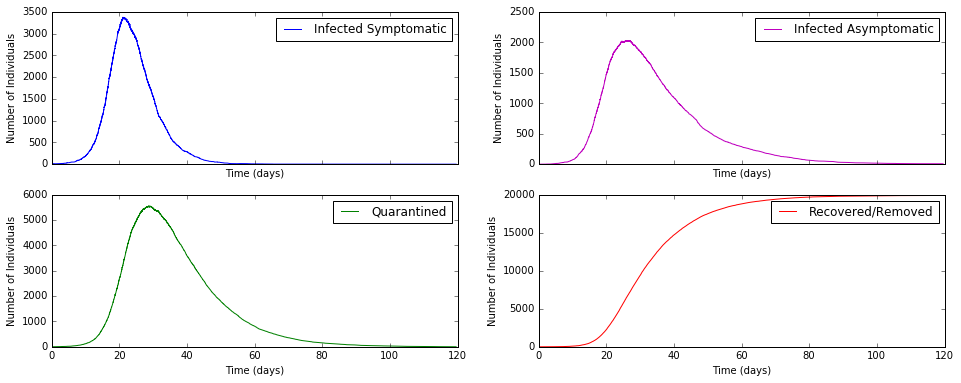

In [100]:
fig, axs = plt.subplots(2, 2,sharex=True, figsize=(16,6))
axs[0, 0].plot(T,I,color='b',label = 'Infected Symptomatic')
#axs[0, 0].set_title('Infected Symptomatic')
axs[0, 1].plot(T,A,color='m',label = 'Infected Asymptomatic')
#axs[0, 1].set_title('Infected Asymptomatic')
axs[1, 0].plot(T,Q, color='g',label='Quarantined')
#axs[1, 0].set_title('Quarantined')
axs[1, 1].plot(T, R, color='r', label='Recovered/Removed')
#axs[1, 1].set_title('Recovered/Removed')

for ax in axs.flat:
    ax.set(xlabel='Time (days)', ylabel='Number of Individuals')
    ax.legend(loc='upper right')

